## Depth estimation with YOLO

### Put left and right videos next to each other:
ffmpeg -i SV_test_video_left.avi_out.mp4 -i SV_test_video_right.avi_out.mp4 -filter_complex hstack=inputs=2 SV_ropes_detected.mp4

Something is a bit weird, cuz it manages to detect more on the first time I used the train 18, but now when I am doing it it is a period where it does not. Dont know why, but should probably train directly on the streo images later anyways. so will not use so much time on that now. 

## Used files

Each line in the files boxes_count_per_image_left.txt and boxes_count_per_image_left.txt shows many detection boxes are found in image frame (of the test images): linenumber. 

Each line in SV_left_test_video.txt and SV_left_test_video.txt gives x1 y1 x2 y2 score class_id
(x1, y1) gives the upper left corner of the box and (x2, y2) gives the down right corner of the box.

Map with key = image frame and value doble list with info of the detection boxes: [[x1, y1, x2, y2, score, class_id],[[x1, y1, x2, y2, score, class_id]]]

In [5]:
def create_map_frame_box_values(path_to_box_count_file, path_to_box_values_file):
    # Initialize an empty map
    frame_map = {}

    # Read the contents of the box count file into a list
    with open(path_to_box_count_file, 'r') as box_count_file:
        box_count_lines = box_count_file.readlines()
        box_count = [int(line.strip()) for line in box_count_lines]

    j = 0
    # Loop through the indices of box_count
    for i in range(len(box_count)):
        # Check the value of box_count at index i
        if box_count[i] == 1:
            # Read the corresponding line from the box values file
            with open(path_to_box_values_file, 'r') as f:
                lines = f.readlines()
                frame_map[i] = [[float(value.rstrip()) for value in lines[j].split()]] # Remove '\n' using rstrip() and convert to float
                j += 1
        elif box_count[i] > 1:
            # Read the corresponding two lines from the box values file
            with open(path_to_box_values_file, 'r') as f:
                lines = f.readlines()
                frame_map[i] = [[float(value.rstrip()) for value in line.split()] for line in lines[j:j+box_count[i]]]  # Remove '\n' using rstrip() for each line and convert to float
                j += box_count[i]
        else:
            # If no box was detected
            frame_map[i] = []

    return frame_map

# Use the function to create the map for left and right images
left_frame_map = create_map_frame_box_values('YOLOvol3/local_env/boxes_count_per_image_left.txt', 'YOLOvol3/local_env/SV_left_test_video.txt')
right_frame_map = create_map_frame_box_values('YOLOvol3/local_env/boxes_count_per_image_right.txt', 'YOLOvol3/local_env/SV_right_test_video.txt')


In [6]:
score_threshold = 0.5

def get_best_score_frames(frame_map, score_threshold):
    best_score_frames = {}
    for frame in frame_map:
        if frame_map[frame]:
            sorted_list = sorted(frame_map[frame], key=lambda x: x[4])
            if sorted_list[-1][4] > score_threshold:
                best_score_frames[frame] = sorted_list[-1]
    return best_score_frames

left_frame_map_best_score = get_best_score_frames(left_frame_map, score_threshold)
right_frame_map_best_score = get_best_score_frames(right_frame_map, score_threshold)


## Midpoint of boxes used for a first test for depth estimation

In [7]:
def get_midpoint_of_box(box_map):
    midpoint_map = {}
    for frame in box_map:
        x1, y1, x2, y2, _, _ = box_map[frame]
        midpoint_map[frame] = [x1 + 0.5 * (x2 - x1), y1 + 0.5 * (y2 - y1)]
    return midpoint_map


midpoint_map_left = get_midpoint_of_box(left_frame_map_best_score)
midpoint_map_right = get_midpoint_of_box(right_frame_map_best_score)

Plan: take the box in the image that has the highest score. And only put a box in a flame if both the left and rthe right image has detected a box with a score over a treshold. 

nb: here it might be boxes that dont correspond to each other, i.e. different roper are detected in the different cameras. However, these one can remove with outlier detection?
- Evt sjekke plassering på boksene, evt. boksene bør ikke være mer enn 1/3 width plassert forskjellig i kameraene
- Form på boksen.

In [8]:
import cv2

def create_video_one_camera_detection(input_video_path, output_video_path, map_camera_best_score_video, map_camera_best_score_not_video, score_threshold, midpoint_map):
    cap = cv2.VideoCapture(input_video_path)
    ret, frame = cap.read()
    H, W, _ = frame.shape
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'avc1'), int(cap.get(cv2.CAP_PROP_FPS)), (W, H))

    idx = 0  # Assuming you want to add the square to the first frame

    while ret:
        if idx in map_camera_best_score_video and idx in map_camera_best_score_not_video:
            x1, y1, x2, y2, _ , _ = map_camera_best_score_video[idx]
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
            cv2.circle(frame, (int(midpoint_map[idx][0]), int(midpoint_map[idx][1])), 5, (0, 255, 0), -1)

        idx += 1
        out.write(frame)
        ret, frame = cap.read()  # Read the next frame


create_video_one_camera_detection('SV_test_video_left.avi', 'SV_test_detection_video_left.mp4', left_frame_map_best_score, right_frame_map_best_score, score_threshold, midpoint_map_left)
create_video_one_camera_detection('SV_test_video_right.avi', 'SV_test_detection_video_right.mp4', right_frame_map_best_score, left_frame_map_best_score, score_threshold, midpoint_map_right)


# Create a stereo Vision video of the left and the right detection videos
!ffmpeg -i SV_test_detection_video_left.mp4 -i SV_test_detection_video_right.mp4 -filter_complex hstack=inputs=2 SV_ropes_detected_synchronous.mp4

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/theabrusevold/miniconda3 --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'SV_test_detect

## Feature matching within boxes

 "Sum of Absolute Differences (SAD)." https://medium.com/@nikhilnair8490/2d-feature-tracking-part-3-feature-matching-72a1bc8dc58a

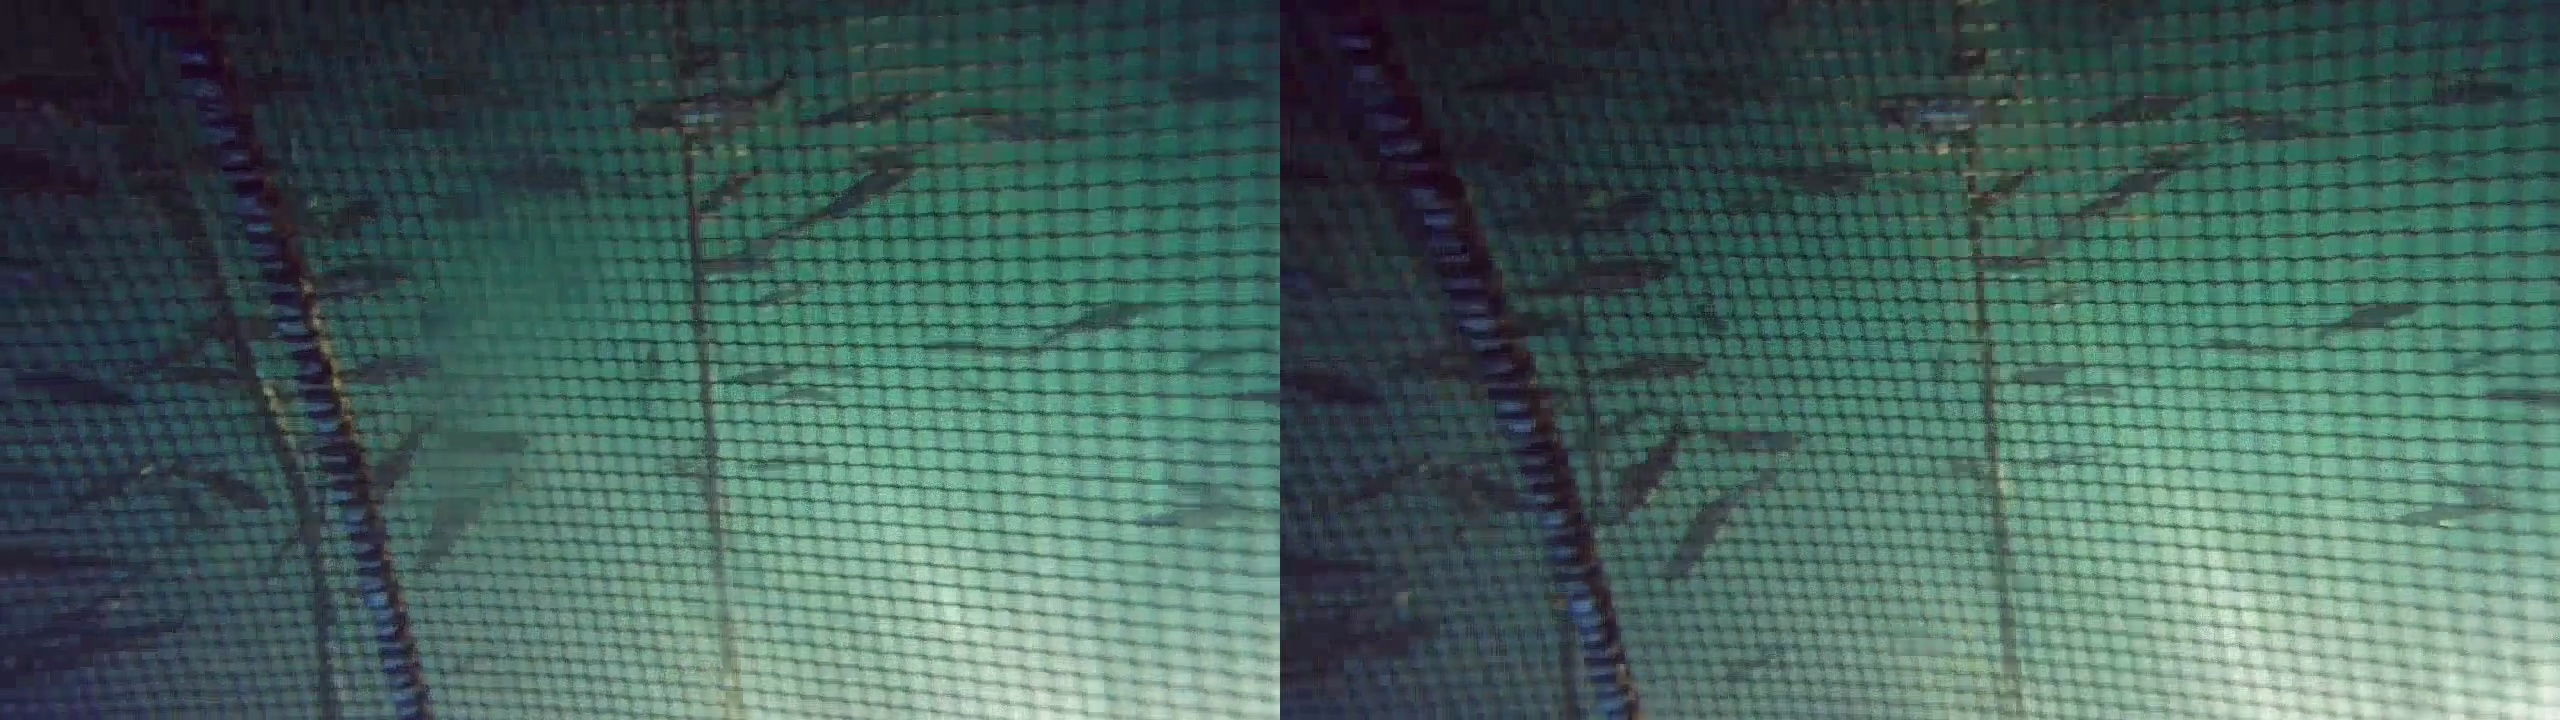

Frame  10  extracted and saved as  frame_10_image.jpg


In [9]:
#First make a smaller image of what is inside the box
import cv2
from IPython.display import Image, display


# Path to the input video file
video_path = 'SV_ropes_detected_synchronous_no_marks.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video file opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Frame number to extract
frame_number = 10

# Set the frame position to frame_number
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame at the specified frame number
ret, frame = cap.read()

# Check if the frame was read successfully
if not ret:
    print("Error: Could not read frame ", frame_number)
    exit()

# Path to save the extracted frame as an image
output_image_path = 'frame_10_image.jpg'

# Save the frame as an image
cv2.imwrite(output_image_path, frame)
display(Image(filename=output_image_path))

# Release the video capture object
cap.release()

print("Frame ", frame_number, " extracted and saved as ", output_image_path)



In [23]:
import cv2
image_width = 1280

# Read the original image
original_image= cv2.imread(f'frame_{frame_number}_image.jpg')

x1_left, y1_left, x2_left, y2_left, _, _ = left_frame_map_best_score[frame_number]

x1_right, y1_right, x2_right, y2_right, _, _ = right_frame_map_best_score[frame_number]

x1_right, x2_right = x1_right + image_width, x2_right + image_width


roi_left = original_image[int(y1_left):int(y2_left), int(x1_left):int(x2_left)]
cv2.imwrite('extracted_roi_left.jpg', roi_left)

roi_right = original_image[int(y1_right):int(y2_right), int(x1_right):int(x2_right)]
cv2.imwrite('extracted_roi_right.jpg', roi_right)


True

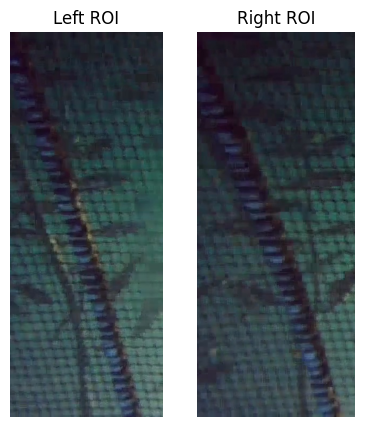

In [27]:
import cv2
import matplotlib.pyplot as plt

# Read the original image
original_image = cv2.imread('frame_10_image.jpg')

# Extract left ROI
roi_left = original_image[int(y1_left):int(y2_left), int(x1_left):int(x2_left)]
cv2.imwrite('extracted_roi_left.jpg', roi_left)

# Extract right ROI
roi_right = original_image[int(y1_right):int(y2_right), int(x1_right):int(x2_right)]
cv2.imwrite('extracted_roi_right.jpg', roi_right)

# Display the extracted ROIs side by side using Matplotlib
plt.figure(figsize=(4.5, 5))

# Display left ROI
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(roi_left, cv2.COLOR_BGR2RGB))
plt.title('Left ROI')
plt.axis('off')

# Display right ROI
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(roi_right, cv2.COLOR_BGR2RGB))
plt.title('Right ROI')
plt.axis('off')

# Show the plot
plt.show()


## Now I want to do SAD: sum of Absolute Difference

error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/core/src/arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


# Shit copied from Load_data cuz im lazy

In [175]:
import os

def extract_image_numbers(left_folder):
    train_numbers = []
    test_numbers = []
    validate_numbers = []

    # Iterate over the left images folders (train, validate, test)
    for folder_name in os.listdir(left_folder):
        # Filter out .DS_Store files and exclude .txt files
        if folder_name == '.DS_Store' or folder_name.endswith('.txt'):
            continue
        
        left_images_folder = os.path.join(left_folder, folder_name)
        
        # Determine which list to append the numbers to based on the folder name
        if folder_name == 'train':
            numbers_list = train_numbers
        elif folder_name == 'test':
            numbers_list = test_numbers
        elif folder_name == 'validate':
            numbers_list = validate_numbers
        else:
            continue
        
        # Iterate over the left images in the current folder
        for left_image_name in os.listdir(left_images_folder):
            # Check if the filename matches the expected pattern and is a JPG file
            if not left_image_name.startswith("left_image_") or not left_image_name.lower().endswith(".jpg"):
                continue
            
            try:
                # Extract the image number from the left image name
                image_number = left_image_name.split("_")[2].split(".")[0]
                
                # Append the number to the appropriate list
                numbers_list.append(int(image_number))
            except IndexError:
                print(f"Ignored {left_image_name} due to invalid filename format")
            except ValueError:
                print(f"Ignored {left_image_name} due to non-numeric image number")

    return train_numbers, test_numbers, validate_numbers

# Replace this path with your actual folder path
left_images_folder = "../data/left"

train_numbers, test_numbers, validate_numbers = extract_image_numbers(left_images_folder)


In [174]:
import rosbag
# Path to your ROS bag file
bag_file_path = "2023-10-31-14-28-26.bag"

# Open the bag file
bag = rosbag.Bag(bag_file_path)

time_stereo = []
# Iterate over the messages in the bag
for topic, msg, t in bag.read_messages(topics=['/ted/image']):
    time_stereo.append(t)

# Have to find the time of the first  message to get when ROV start
for topic, msg, t in bag.read_messages():
    ROV_start_time = t # time since last epoch [ns]
    break

In [176]:
time_SV_test = []

for i in range(len(time_stereo)):
    for frame in sorted(test_numbers):
        if i == frame:
            time_SV_test.append((time_stereo[i] - ROV_start_time).to_sec())

print(len(time_SV_test))
print(time_SV_test)

2737
[35.830105, 35.8679197, 35.8988517, 35.9447749, 35.9767273, 36.0192066, 36.099278, 36.1738789, 36.2217567, 36.2647192, 36.2997054, 36.3475485, 36.4701439, 36.4970518, 36.540301, 36.5752489, 36.6328873, 36.7037029, 36.7501413, 36.7864084, 36.8291279, 36.8711201, 36.9024796, 36.9501812, 36.9771565, 37.0269883, 37.0734495, 37.102649, 37.1813528, 37.2208281, 37.2667463, 37.2974484, 37.3399444, 37.3738068, 37.4974814, 37.5421648, 37.6191598, 37.6629223, 37.6997075, 37.7406704, 37.786398, 37.8220543, 37.8685024, 37.8998552, 37.9351745, 37.9942571, 38.0178258, 38.0690304, 38.0973578, 38.1427692, 38.1946533, 38.2201652, 38.2664032, 38.2989862, 38.3404629, 38.3888377, 38.4268753, 38.47207, 38.5013423, 38.545052, 38.5726014, 38.6177679, 38.6993725, 38.740918, 38.7734338, 38.8194641, 38.8617832, 38.9368007, 38.9846053, 39.015741, 39.0619764, 39.1067453, 39.1389167, 39.1837761, 39.2166207, 39.2604277, 39.3450633, 39.3863716, 39.431898, 39.4647259, 39.5122973, 39.5483307, 39.5871857, 39.621935

## Triangulation

In [255]:
import numpy as np
baseline_distance = 13 # cm
focal_length = 2.97 # mm  # must make sure what hte focal length is!!

alpha = 80 # degrees
width_image = 1280


# Need focal length in pixels
f_pixel = (width_image * 0.5) / np.tan(alpha * 0.5 * np.pi/180)

depth_list = []
time_list = []

for frame in range(len(left_frame_map)):
    if frame in midpoint_map_left and frame in midpoint_map_right:
        x_left = midpoint_map_left[frame][0]
        x_right = midpoint_map_right[frame][0]
        #depth = (baseline_distance * focal_length) / (x_left - x_right)
        depth = (baseline_distance * f_pixel) / (x_left - x_right)
        depth_list.append(depth)

        time_list.append(time_SV_test[frame])


In [247]:
net_dist_d = []
time_dist_d = []

for topic, msg, t in bag.read_messages(topics=['/gui/netFollowing_manager']):
    net_dist_d.append(msg.d_net_distance * 100)
    time_d = (t - ROV_start_time).to_sec()
    time_dist_d.append(time_d)

print(net_dist_d)
print(time_dist_d)




[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.00000238418579, 189.9999976158142, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 209.99999046325684, 

# Depth

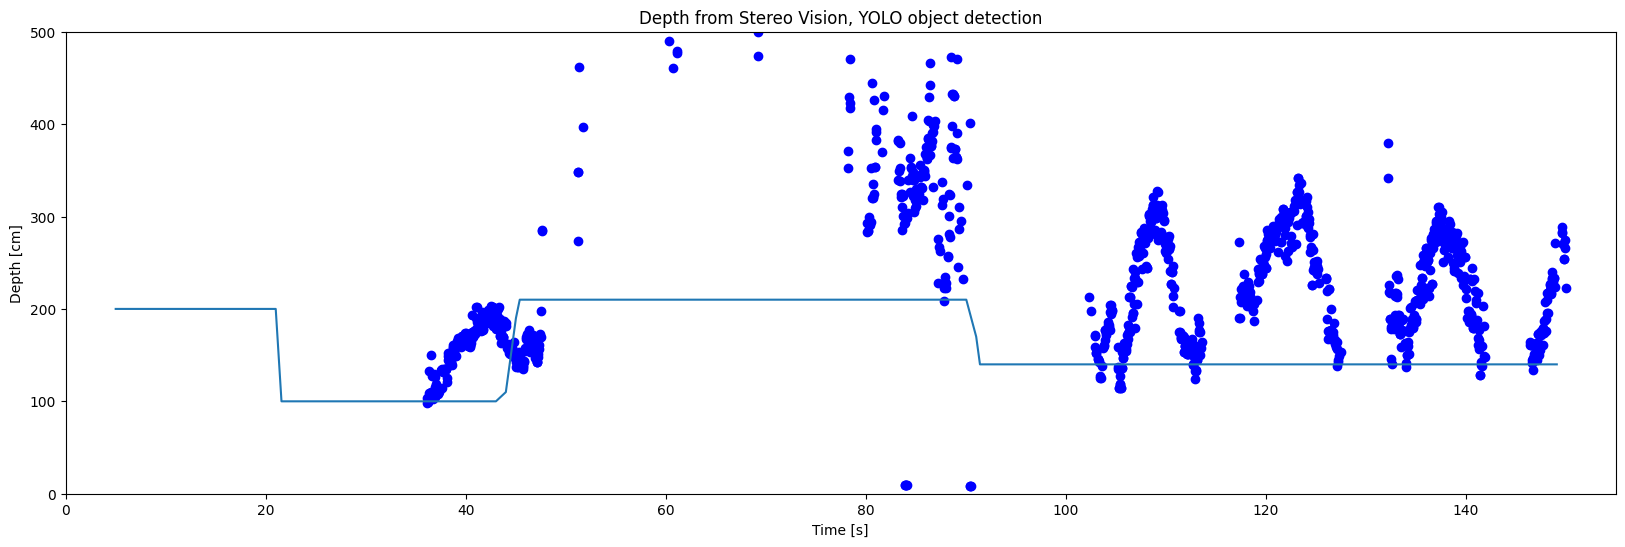

In [258]:
import matplotlib.pyplot as plt

# Assuming time_SV_test and depth_list are your arrays of time and depth data respectively
# Make sure both arrays have the same length

# Plotting
plt.figure(figsize=(20, 6))
plt.scatter(time_list, depth_list, color='blue')
plt.plot(time_dist_d,net_dist_d)

# Adding labels and title
plt.xlabel('Time [s]')
plt.ylabel('Depth [cm]')
plt.title('Depth from Stereo Vision, YOLO object detection')
plt.xlim(0,155)
plt.ylim(0,500)

# Display the plot
plt.show()


Reason for the sine curves at 150 cm is that now im just taking the middle point of the box. an dthe ox is going bigger and smaller bacause of the rope beiung vertical-diagonal-vertical. I think.